In [1]:
import astropy.units as u
import numpy as np
from astroquery.simbad import Simbad
import astropy.coordinates as coord

from astropy.io import ascii
from astropy.io import fits
import os.path
# 
import elk
from elk.ensemble import EnsembleLC
from elk.lightcurve import BasicLightcurve

from astropy.table import Table, join, MaskedColumn, vstack, Column
from matplotlib import pyplot as plt


path = '/uufs/chpc.utah.edu/common/home/astro/zasowski/sinha/fits/'
plt.style.use(path +'paper_style.mplstyle')
plt.rcParams["font.family"] = "STIXGeneral"
plt.rcParams['text.usetex'] = True

In [2]:
cluster_summary_stats = Table.read('cluster_summary_statistics.fits')

In [3]:
age_path = '/uufs/chpc.utah.edu/common/home/astro/zasowski/sinha/tess_data/data/'

mw=Table.read(age_path + 'Use_MW.fits')

smc=Table.read(age_path + 'Bica_Cut_down.fits')

lmc=Table.read(age_path + 'Glatt_Cut_down.fits')


In [6]:
ages=[]
location = []
for name in list(cluster_summary_stats['summary_fname']):
    for i in range(len(mw)):
        if mw[i]['NAME']== name:
            ages.append(mw[i]['LOG_AGE'])
            location.append('MW')
    
    for j in range(len(smc)):
        if smc[j]['SimbadName']==name:
            ages.append(smc[j]['logAge'])
            location.append('SMC')
            
    for k in range(len(lmc)):
        if lmc[k]['SimbadName']==name:
            ages.append(lmc[k]['Age'])
            location.append('LMC')
        
cluster_summary_stats['age'] = ages
cluster_summary_stats['location'] = location

cluster_summary_stats.colnames

['cluster_name',
 'summary_fname',
 'n_rows',
 'snr_05',
 'snr_25',
 'snr_34',
 'snr_50',
 'snr_68',
 'snr_75',
 'snr_95',
 'rms_05',
 'rms_25',
 'rms_34',
 'rms_50',
 'rms_68',
 'rms_75',
 'rms_95',
 'std_05',
 'std_25',
 'std_34',
 'std_50',
 'std_68',
 'std_75',
 'std_95',
 'MAD_05',
 'MAD_25',
 'MAD_34',
 'MAD_50',
 'MAD_68',
 'MAD_75',
 'MAD_95',
 'sigmaG_05',
 'sigmaG_25',
 'sigmaG_34',
 'sigmaG_50',
 'sigmaG_68',
 'sigmaG_75',
 'sigmaG_95',
 'skewness_05',
 'skewness_25',
 'skewness_34',
 'skewness_50',
 'skewness_68',
 'skewness_75',
 'skewness_95',
 'von_neumann_ratio_05',
 'von_neumann_ratio_25',
 'von_neumann_ratio_34',
 'von_neumann_ratio_50',
 'von_neumann_ratio_68',
 'von_neumann_ratio_75',
 'von_neumann_ratio_95',
 'J_Stetson_05',
 'J_Stetson_25',
 'J_Stetson_34',
 'J_Stetson_50',
 'J_Stetson_68',
 'J_Stetson_75',
 'J_Stetson_95',
 'max_power_05',
 'max_power_25',
 'max_power_34',
 'max_power_50',
 'max_power_68',
 'max_power_75',
 'max_power_95',
 'freq_at_max_power_05'

In [11]:
stats = ['rms','std','MAD','sigmaG','skewness','von_neumann_ratio','J_Stetson','max_power','freq_at_max_power','n_peaks','ratio_of_power_at_high_v_low_freq'
         ,'FAP','max_autocorrelation','time_of_max_autocorrelation']

len(stats)

14

# ALL CLUSTERS

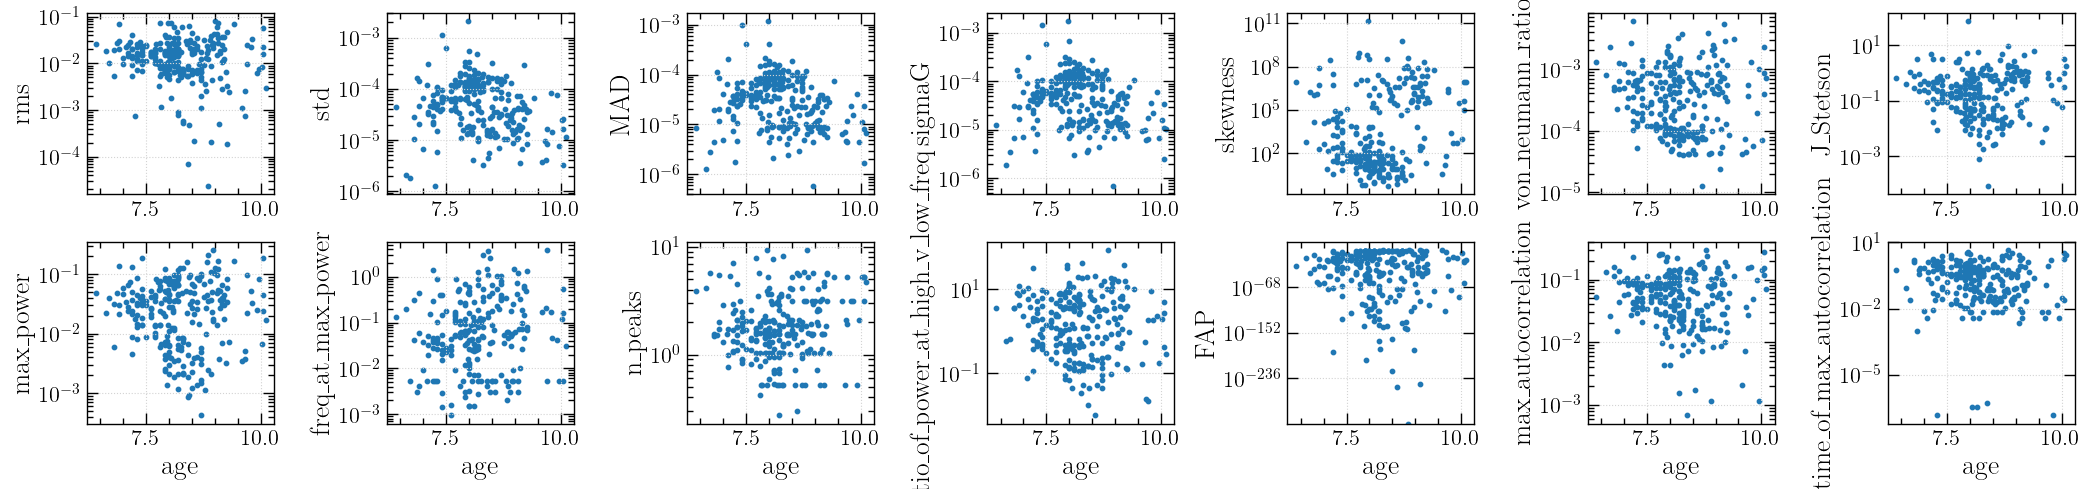

In [17]:
row = 0
col = 0
fig,ax = plt.subplots(2,7,figsize=(21,5))
for i in stats:
    ax[row][col].scatter(cluster_summary_stats['age'],(cluster_summary_stats['{}_95'.format(i)] - cluster_summary_stats['{}_05'.format(i)]) / np.sqrt(cluster_summary_stats['n_rows']),s=10)
    # ax[col].axhline(y=0.3)
    ax[row][col].set_yscale('log')
    ax[row][col].set_ylabel(i,fontsize=20)
    ax[1][col].set_xlabel('age',fontsize=20)
    col +=1

    if col == 7:
        row +=1
        col = 0
plt.tight_layout()

In [59]:
rms_spread = (cluster_summary_stats['rms_95'] - cluster_summary_stats['rms_05']) / np.sqrt(cluster_summary_stats['n_rows'])
truth = rms_spread < np.nanmedian(cluster_summary_stats['rms_95']) - np.nanmedian(cluster_summary_stats['rms_05'])

subset_cols = ['std','skewness','max_power','freq_at_max_power','max_autocorrelation','time_of_max_autocorrelation','J_Stetson']

for i in subset_cols:
    spread = (cluster_summary_stats['{}_95'.format(i)] - cluster_summary_stats['{}_05'.format(i)]) / np.sqrt(cluster_summary_stats['n_rows'])
    col_truth = spread < np.nanmedian(cluster_summary_stats['{}_95'.format(i)]) - np.nanmedian(cluster_summary_stats['{}_05'.format(i)])
    truth = truth & col_truth


cluster_summary_stats['gold'] = truth

bad_clusters_charlie = ['NGC1704','[SL63] 410','NGC1932',
                        '[SL63] 106','NGC 129','IC 2581',
                        '[SL63] 763','BSDL1674','NGC2000']

bad_cluster_truth = np.isin(list(cluster_summary_stats['summary_fname']),bad_clusters_charlie)
cluster_summary_stats['gold'] = cluster_summary_stats['gold'] & (bad_cluster_truth==False)

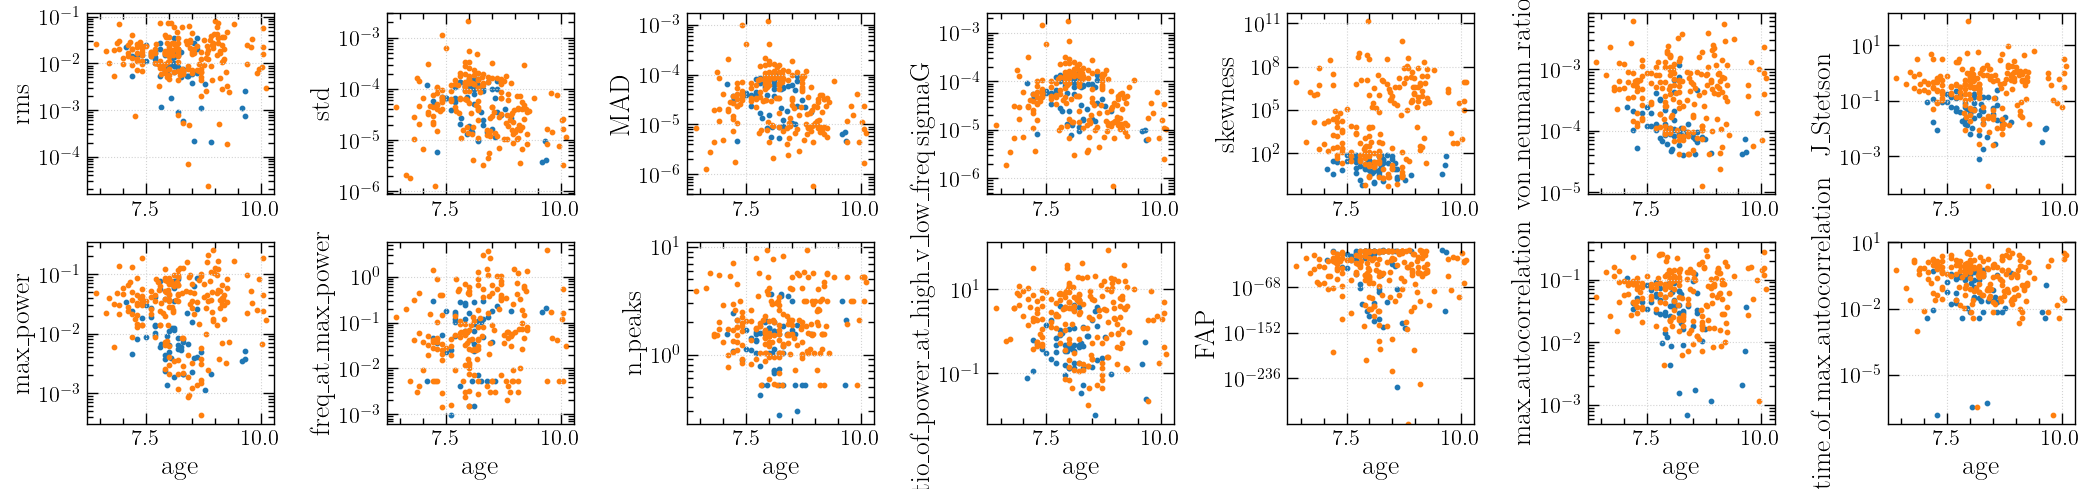

In [60]:
gold_sample = cluster_summary_stats[cluster_summary_stats['gold']==True]
other_sample = cluster_summary_stats[cluster_summary_stats['gold']==False]

row = 0
col = 0
fig,ax = plt.subplots(2,7,figsize=(21,5))
for i in stats:
    
    ax[row][col].scatter(gold_sample['age'],(gold_sample['{}_95'.format(i)] - gold_sample['{}_05'.format(i)]) / np.sqrt(gold_sample['n_rows']),s=10)
    ax[row][col].scatter(other_sample['age'],(other_sample['{}_95'.format(i)] - other_sample['{}_05'.format(i)]) / np.sqrt(other_sample['n_rows']),s=10)
    # ax[col].axhline(y=0.3)
    ax[row][col].set_yscale('log')
    ax[row][col].set_ylabel(i,fontsize=20)
    ax[1][col].set_xlabel('age',fontsize=20)
    col +=1

    if col == 7:
        row +=1
        col = 0
plt.tight_layout()


In [62]:
#looking for variablity sector to sector
#gold sample: viewed 3 times
#small spread across sector
#think about handling numbers of sectors for std
#look at bad sectors (look at median and then wings)

/scratch/local/u1363702/10689100/ipykernel_3733018/2850978232.py:7: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stats.ks_2samp([], uniform_age_distribution)


KstestResult(statistic=np.float64(nan), pvalue=np.float64(nan), statistic_location=np.float64(nan), statistic_sign=np.float64(nan))

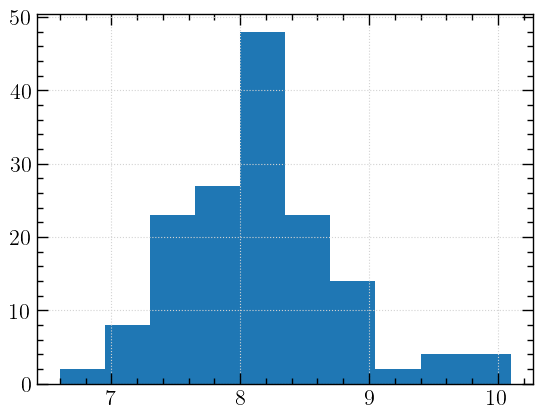

In [94]:
from scipy import stats
np.random.seed(0)
plt.hist(gold_sample['age'])


stats.ks_2samp([], uniform_age_distribution)

In [206]:
indices = np.arange(0, len(gold_sample))

temp = []
key = False

count = 0

while(key==False):
    idx = np.random.randint(0, len(indices))
    indices = np.delete(indices,idx)

    temp.append(gold_sample[idx])
    temp_resampled_gold = vstack(temp)

    if len(temp_resampled_gold) >5:
        ks_stats = []
        for i in range(10):
            uniform_age_distribution = np.random.uniform(np.nanmin(temp_resampled_gold['age']),np.nanmax(temp_resampled_gold['age']),len(temp_resampled_gold))
            ks_stat = stats.ks_2samp(temp_resampled_gold['age'], uniform_age_distribution)
            ks_stats.append(ks_stat.pvalue)
        if np.nanmedian(ks_stats) > 0.05:
            resampled_gold = vstack(temp)
        else:
            del temp[-1]
    if len(indices) == 0:
        key = True
        
            
        #     key = True
        #     print(ks_stats)
        # else:
        #     resampled_gold = vstack(temp)
            

    count +=1
    if count > 5000:
        key=True
        print('WARN!!!')
    
    
    

/uufs/astro.utah.edu/common/home/u1363702/software/pkg/miniforge3/envs/tess/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)


In [207]:
resampled_gold

cluster_name,summary_fname,n_rows,snr_05,snr_25,snr_34,snr_50,snr_68,snr_75,snr_95,rms_05,rms_25,rms_34,rms_50,rms_68,rms_75,rms_95,std_05,std_25,std_34,std_50,std_68,std_75,std_95,MAD_05,MAD_25,MAD_34,MAD_50,MAD_68,MAD_75,MAD_95,sigmaG_05,sigmaG_25,sigmaG_34,sigmaG_50,sigmaG_68,sigmaG_75,sigmaG_95,skewness_05,skewness_25,skewness_34,skewness_50,skewness_68,skewness_75,skewness_95,von_neumann_ratio_05,von_neumann_ratio_25,von_neumann_ratio_34,von_neumann_ratio_50,von_neumann_ratio_68,von_neumann_ratio_75,von_neumann_ratio_95,J_Stetson_05,J_Stetson_25,J_Stetson_34,J_Stetson_50,J_Stetson_68,J_Stetson_75,J_Stetson_95,max_power_05,max_power_25,max_power_34,max_power_50,max_power_68,max_power_75,max_power_95,freq_at_max_power_05,freq_at_max_power_25,freq_at_max_power_34,freq_at_max_power_50,freq_at_max_power_68,freq_at_max_power_75,freq_at_max_power_95,n_peaks_05,n_peaks_25,n_peaks_34,n_peaks_50,n_peaks_68,n_peaks_75,n_peaks_95,ratio_of_power_at_high_v_low_freq_05,ratio_of_power_at_high_v_low_freq_25,ratio_of_power_at_high_v_low_freq_34,ratio_of_power_at_high_v_low_freq_50,ratio_of_power_at_high_v_low_freq_68,ratio_of_power_at_high_v_low_freq_75,ratio_of_power_at_high_v_low_freq_95,FAP_05,FAP_25,FAP_34,FAP_50,FAP_68,FAP_75,FAP_95,max_autocorrelation_05,max_autocorrelation_25,max_autocorrelation_34,max_autocorrelation_50,max_autocorrelation_68,max_autocorrelation_75,max_autocorrelation_95,time_of_max_autocorrelation_05,time_of_max_autocorrelation_25,time_of_max_autocorrelation_34,time_of_max_autocorrelation_50,time_of_max_autocorrelation_68,time_of_max_autocorrelation_75,time_of_max_autocorrelation_95,WARN,age,location,gold
bytes47,bytes17,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,str3,bool
hlsp_elk_tess_ffi_sl63-527_tess_v1_llc,[SL63] 527,45,2.9240618089590247,2.994659561029369,3.0521888406574664,3.1730933481823773,3.2202690337107946,3.38311923570267,3.4900457574977697,0.00931362493258981,0.00931362493258981,0.012232149776984317,0.03384793704114787,0.03497040149136789,0.053071430958243744,0.09929040879277785,0.0005196214959327332,0.0006475962136535768,0.0006629866873312642,0.0008262190965624627,0.0009941204063776486,0.001017298008394461,0.0012585288897687674,0.0002923325797275611,0.00041427028923374243,0.0004267698004258147,0.00048455233979766144,0.0006049456823896372,0.0006186288096181602,0.0008500888865955569,0.00043323839309750573,0.0006139520150990175,0.0006350955560004588,0.0007189543358273586,0.0008970074658235155,0.0009165078972627419,0.0012599915720557038,-0.19364969893285336,5.8878323540848685,8.241408169103307,12.497298251637062,123.69902041147962,130.6896524956127,260.73724036913876,9.472773299072566e-06,1.3409530367294736e-05,1.6089858137228294e-05,4.7342073874205366e-05,0.00015813102298581304,0.00017454393750358644,0.0006972392624800574,0.8035284119626742,0.8369525822723902,0.8837609743409457,0.8980171433352553,0.9619893517348971,0.9999884369778893,1.1825314110339618,0.0024180056184280405,0.002943587329804395,0.004192320011848011,0.010037137281267556,0.014927510122319845,0.016557404234689224,0.06626201246037908,0.19000000000000003,0.30000000000000004,0.30000000000000004,0.30000000000000004,0.30000000000000004,0.460000

(array([23., 11., 15., 17., 11., 13., 11., 14., 13., 20.]),
 array([7.01222508, 7.22686506, 7.44150504, 7.65614502, 7.87078501,
        8.08542499, 8.30006497, 8.51470496, 8.72934494, 8.94398492,
        9.15862491]),
 <BarContainer object of 10 artists>)

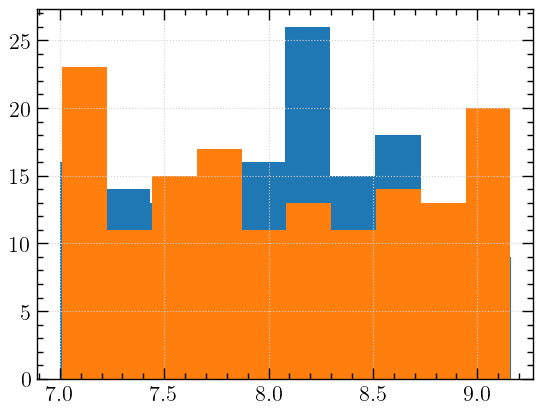

In [222]:
uniform_age_distribution = np.random.uniform(np.nanmin(resampled_gold['age']),np.nanmax(resampled_gold['age']),len(resampled_gold))

plt.figure()
plt.hist(resampled_gold['age'])
plt.hist(uniform_age_distribution)

In [223]:
ks_stats = stats.ks_2samp(resampled_gold['age'], uniform_age_distribution)
ks_stats

KstestResult(statistic=np.float64(0.13513513513513514), pvalue=np.float64(0.1341333624322534), statistic_location=np.float64(8.55), statistic_sign=np.int8(1))

In [225]:
resampled_gold.remove_column('WARN')

In [227]:
resampled_gold.write('gold_cluster_sample_stats.fits',overwrite=True)